In [83]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
sys.path.append("../../")
import helpers
import glm
import math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Heterogeneous Material Matching
Uptill now we have considered material matching of objects consisting of just a single material / color. In the real world objects hardly ever consist of just a single material. In this notebook we will look at objects consisting of multiple materials such as the bunny below.

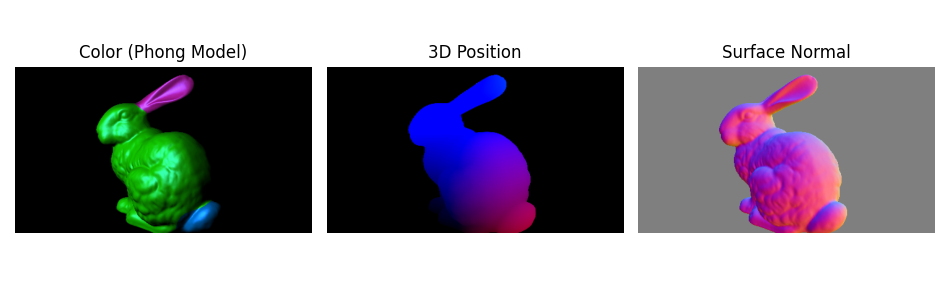

In [84]:
positions = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week5", "position0001.exr"), 0.25, nn_interpolation=True)
normals = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week5", "normal0001.exr"), 0.25, nn_interpolation=True)

camera_pos = glm.vec3(2, -2, 1.5)
light_color = glm.vec3(0.8, 0.8, 0.8)

colors = []
light_positions = []
folder = os.path.join(helpers.dataset_folder, "week5", "heterogeneous")
for i in range(20):
    colors.append(np.load(os.path.join(folder, f"bunny{i}.npy")))
    light_positions.append(np.load(os.path.join(folder, f"bunny{i}_light_pos.npy")))

helpers.show_images({
    "Color (Phong Model)": np.clip(colors[4], 0, 1),
    "3D Position": positions,
    "Surface Normal": normals / 2 + 0.5
}, nrows=1, ncols=3)

##  Estimating the material map
To model an object consisting of multiple materials we will estimate a "*material map*". The material map assigns a material index to each image pixel. This material map can later be used to estimate the different BRDFs separately (see notebook 5.1).

As the color image above illustrates (left), the most dominant part of the Phong model is the diffuse term. The estimate of the $k_d$ parameter is thus a good differentiating factor between the different materials that the objects is made out of.

We need to estimate $k_d$ without knowing $k_s$ or $t$. Recall the Phong equation and how it is made up out of the diffuse component (left side) and the specular component (right side):

$$
C=k_d I (L \cdot N) + k_s I (E \cdot R)^t
$$

The specular component mostly varies by $E \cdot R$. If this value is low then the specular component will contribute very little to the pixel color (assuming $t>1$). We can use this knowledge to estimate $k_d$ by looking only at those pixels where $E \cdot R$ is low and estimating $k_d$ as if the specular component is zero, such that $C \approx k_d I (L \cdot N)$.


### Exercise 6 (2 points)
Implement the function `estimate_kd_per_pixel` which estimates the $k_d$ parameter using the method above. Compute for each pixel & light position whether $E \cdot R$ is low, and if so, estimate $k_d$ as if the specular contribution is zero. Each pixel should have at least one $k_d$ estimate, combine these (e.g. mean or median) to get a single estimate per pixel.

*Hint:* There may be some visual artefacts in your result (see "Tests of exercise 6")

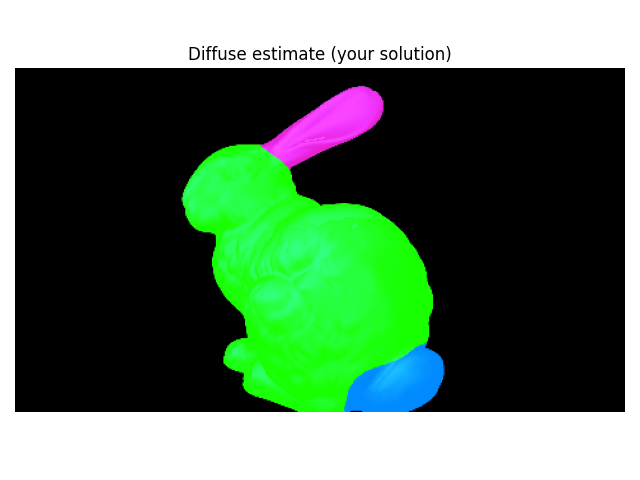

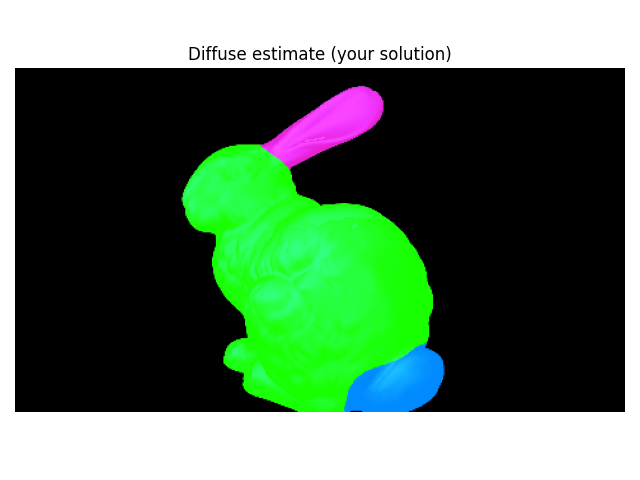

In [85]:
def estimate_kd_per_pixel(light_color, light_positions, observer_position, pixels):
    kd_estimates = []  # Store kd for each pixel

    for surface_normal, surface_position, all_images in pixels:
        current_estimates = []
        for light_position, observed_color in zip(light_positions, all_images):
            L = glm.normalize(light_position - surface_position)
            E = glm.normalize(observer_position - surface_position)
            R = glm.reflect(-L, surface_normal)
            N_dot_L = max(0, np.dot(surface_normal, L))

            if N_dot_L > 0.1:
                kd = observed_color / (light_color * N_dot_L)
                current_estimates.append(kd)


        if current_estimates:
            avg_kd = np.mean(current_estimates, axis=0)
        else:
            avg_kd = 0
        kd_estimates.append(avg_kd)

    assert len(kd_estimates) == len(pixels)
    return kd_estimates


# Get surface normal, surface position and observed color for each non-background pixel.
pixels = list(zip(normals.reshape(-1, 3), positions.reshape(-1, 3), zip(*[c.reshape(-1, 3) for c in colors])))
pixels = [pixel for pixel in pixels if np.dot(pixel[0], pixel[0]) > 0]

# Take a couple of pictures with our virtual camera
kd_estimate = estimate_kd_per_pixel(light_color, light_positions, camera_pos, pixels)

kd_estimate_image = np.zeros((np.prod(normals.shape[:2]), 3))
kd_estimate_image[np.all(normals.reshape(-1, 3) != 0, axis=1)] = kd_estimate
kd_estimate_image = kd_estimate_image.reshape(normals.shape)

helpers.show_image(kd_estimate_image, "Diffuse estimate (your solution)")

### Tests of exercise 6
Your code should make a decent estimate of $k_d$ at every pixel. There may be some visual artefacts thus this exercise will be tested with a large margin of error (Sum of Squared Differences of $0.01$ average per pixel).

In [86]:
# Add your own tests here

In [87]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL

import warnings
warnings.filterwarnings("ignore")

reference_kd_image = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week5", "bunny_heterogeneous_kd2.png"), 0.25, nn_interpolation=True)
print(f"SSD per pixel: {helpers.SSD_per_pixel(kd_estimate_image, reference_kd_image)}")
assert(helpers.SSD_per_pixel(kd_estimate_image, reference_kd_image) < 0.01)


SSD per pixel: 0.004533727411297373


## Grouping similar pixels
We now have a map containing the (estimated) diffuse parameter $k_d$ for each pixel. Our goal is to assign to each pixel a number to indicate to which of the three materials (pink/green/blue) it belongs. An effective and (relatively) simple algorithm to do so is *k-means* clustering.

*k-means clustering* works as follows:
* Initialize the cluster centers to random input points
* Loop:
  * Assign input points to the nearest cluster center
  * Compute new cluster centers as the mean of the points belonging to that cluster

The random initalization may sometimes lead to the algorithm getting stuck in a suboptimal solution. Common practice is to repeat the process multiple times and take the best result. We provide our own `kmeans(samples, num_clusters)` implementation so you don't need to use `cv2.kmeans` (which is more complex and error prone).

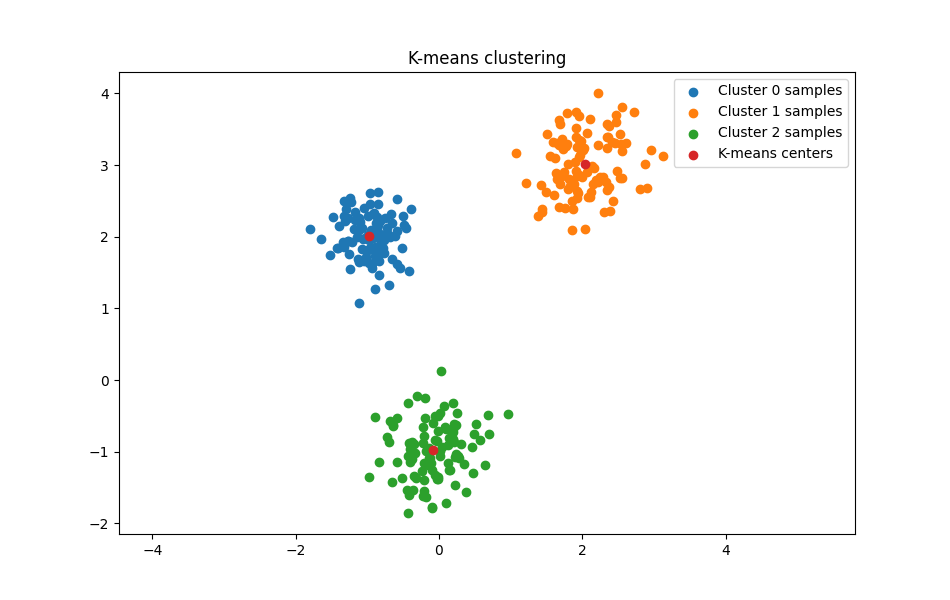

In [88]:
def kmeans(samples, num_clusters, max_iterations = 20, num_attempts = 50):
    best_SSD = None
    best_clusters = None
    best_centers = None
    
    for _ in range(num_attempts):
        # Initialize centers to random samples
        indices = np.random.permutation(np.arange(len(samples)))[:num_clusters]
        centers = samples[indices]
        
        for _ in range(max_iterations):
            dists = np.zeros((len(samples), num_clusters))
            for i, center in enumerate(centers):
                dists[:, i] = np.linalg.norm(samples - centers[i], axis=1)

            clusters = np.argmin(dists, axis=1)
            for i in range(num_clusters):
                # If none of the samples were assigned to one cluster (can happen if both centers perfectly overlap) then
                # we stop the iteration.
                if not np.any(clusters == i):
                    break
                centers[i] = np.mean(np.compress(clusters == i, samples, axis=0), axis=0)
               
            my_SSD = 0
            for i in range(num_clusters):
                vecs_to_cluster_center = np.compress(clusters == i, samples, axis=0) - centers[i]
                dists_to_cluster_center = np.linalg.norm(vecs_to_cluster_center, axis=1)
                my_SSD += np.sum(dists_to_cluster_center**2)

            if not best_SSD or my_SSD < best_SSD:
                best_SSD = my_SSD
                best_clusters = clusters
                best_centers = centers
    
    return best_clusters, best_centers

np.random.seed(890329)
samples1 = np.random.normal((2,3), 0.4, (100,2))
samples2 = np.random.normal((-1,2), 0.3, (100,2))
samples3 = np.random.normal((0,-1), 0.4, (100,2))
samples = np.vstack([samples1, samples2, samples3])
np.random.shuffle(samples)

labels, centers = kmeans(samples, 3, 20, 10)

labels_reference = np.load(os.path.join(helpers.dataset_folder, "week5", "kmeans_example_labels.npy"))
centers_reference = np.load(os.path.join(helpers.dataset_folder, "week5", "kmeans_example_centers.npy"))

def plot_axis(ax, labels, centers):
    ax.set_title("K-means clustering")
    ax.axis("equal")
    for i in range(3):
        ax.scatter(samples[labels==i,0], samples[labels==i,1], label=f"Cluster {i} samples")
    ax.scatter(centers[:,0], centers[:,1], label="K-means centers")
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
plot_axis(ax, labels, centers)
#fig.show()

### Exercise 7 (1 point)
Implement a function that uses `kmeans` to compute the "*material map*". Assign an unique number `i` in the range of `0 <= i < num_materials` to each material and construct the material map: an image that stores for each pixel the number that you assigned to the material at that pixel. Background pixels (where `mask[y,x] == 0`) do not have to be assigned a specific value.

For example when `num_materials` is 4, each non-background pixel should be assigned either `0`, `1`, `2` or `3` to indicate which of the four materials it belongs to.

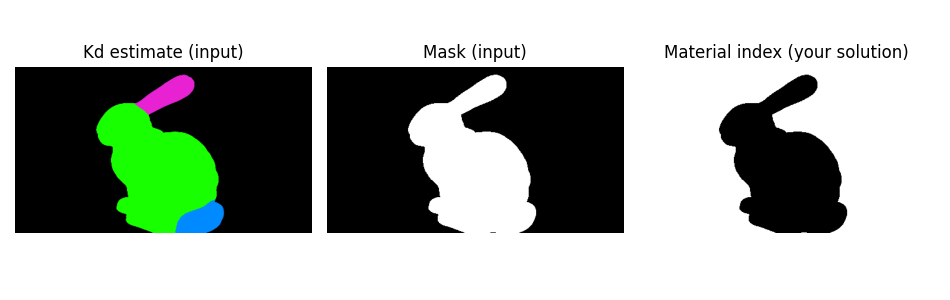

In [ ]:
def group_pixels_by_material(diffuse_image, mask, num_materials):
    # Return an image with at each pixel an **integer** value i between 0 <= i < num_materials.
    out = np.zeros(diffuse_image.shape[:2], int)
    # TODO: Assign a material id to each non background pixel.
    # The arguments for kmeans are as follows:
    # labels, cluster_centers = kmeans(data_points, num_clusters)
    #
    # Inputs:
    #  * data_points:  array of shape (N, D) where N is the number of inputs and D is the number of dimensions (e.g. 100x3 for 100 3D points)
    #  * num_clusters: number of clusters that you want to find
    # 
    # Outputs:
    #  * labels:   array of size N (see data_points) storing at labels[i] an integer indicating the cluster to which data_points[i] belongs. 
    #  * clusters: the center of each cluster (the mean of all data_points assigned to that cluster.
    # YOUR CODE HERE
    
    return out

num_clusters = 3
reference_kd_image = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week5", "bunny_heterogeneous_kd2.png"), 0.25, nn_interpolation=True)
mask = np.sum(np.abs(positions), axis=2) > 0
material_ids = group_pixels_by_material(reference_kd_image, mask, num_clusters)

helpers.show_images({
    "Kd estimate (input)": reference_kd_image,
    "Mask (input)": mask,
    "Material index (your solution)": material_ids / num_clusters + np.invert(mask) * num_clusters # White background
}, nrows=1, ncols=3)

### Tests of exercise 7
Visually verify that pixels are grouped correctly according to color.

In [90]:
# Add your own tests here.

In [91]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL
